In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax 
import jax.numpy as jnp
from jax.lib import xla_bridge
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
print(f"number of cores:", jax.local_device_count())
print(f"using: ", xla_bridge.get_backend().platform)

number of cores: 8
using:  cpu


In [2]:
def dot(v1, v2):
    return jax.numpy.dot(v1, v2)

dot(jax.numpy.array([1.0, 1, 1]), jax.numpy.array([1, 2,-1]))

Array(2., dtype=float64)

In [3]:
from jax import random
rng_key = random.PRNGKey(42)

vs = random.normal(rng_key, shape=(1000,3))
v1s = vs[:500, :]
v2s = vs[500:, :]

In [4]:
vs.shape, v1s.shape, v2s.shape
dot(v1s, v2s.T).shape, dot(v1s.T, v2s).shape

((500, 500), (3, 3))

In [5]:
# [dot(v1s[i], v2s[i]) for i in range(v1s.shape[0])]
data = [dot(v1, v2) for v1, v2 in zip(v1s, v2s)]
data[:5]

[Array(0.21132101, dtype=float64),
 Array(0.13949536, dtype=float64),
 Array(-0.54811178, dtype=float64),
 Array(-0.12914456, dtype=float64),
 Array(-2.5833737, dtype=float64)]

In [7]:
# manual vectorization

def dot_vectorized(v1s, v2s):
    return jnp.einsum("ij,ij->i", v1s, v2s)

dot_vectorized(v1s, v2s)[:5]


Array([ 0.21132101,  0.13949536, -0.54811178, -0.12914456, -2.5833737 ],      dtype=float64)

Automatic vectorization

In [8]:
dot_vmapped = jax.vmap(dot)
dot_vmapped(v1s, v2s)[:5]

Array([ 0.21132101,  0.13949536, -0.54811178, -0.12914456, -2.5833737 ],      dtype=float64)

In [9]:
dot_vectorized_jitted = jax.jit(dot_vectorized)
dot_vmapped_jitted = jax.jit(dot_vmapped)

In [10]:
%timeit [dot(v1, v2) for v1, v2 in zip(v1s, v2s)]
%timeit dot_vectorized(v1s, v2s).block_until_ready()
%timeit dot_vmapped(v1s, v2s).block_until_ready()

5.15 ms ± 54.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
135 µs ± 171 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
543 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
%timeit dot_vectorized_jitted(v1s, v2s).block_until_ready()
%timeit dot_vmapped_jitted(v1s, v2s).block_until_ready()

6.5 µs ± 12.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.39 µs ± 13.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
jax.make_jaxpr(dot)(jnp.array([1.0, 1, 1]), jnp.array([1, 2,-1]))

{ lambda ; a:f64[3] b:i64[3]. let
    c:f64[] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      preferred_element_type=float64
    ] a b
  in (c,) }

In [13]:
jax.make_jaxpr(dot_vectorized)(v1s, v2s)

{ lambda ; a:f64[500,3] b:f64[500,3]. let
    c:f64[500] = dot_general[
      dimension_numbers=(([1], [1]), ([0], [0]))
      preferred_element_type=float64
    ] a b
  in (c,) }

In [14]:
jax.make_jaxpr(dot_vmapped)(v1s, v2s)

{ lambda ; a:f64[500,3] b:f64[500,3]. let
    c:f64[500] = dot_general[
      dimension_numbers=(([1], [1]), ([0], [0]))
      preferred_element_type=float64
    ] a b
  in (c,) }

Controlling array axes to map over

In [15]:
# dot_vmapped = jax.vmap(dot, in_axes=(0, 0))

In [18]:
print(jax.vmap(dot, in_axes=(0, 0))(v1s, v2s).shape)
print(jax.vmap(dot, in_axes=(1, 1))(v1s, v2s).shape)

(500,)
(3,)


In [20]:
# assignment copies the array, in contrast to numpy
x1 = jnp.array([1.0, 1.0, 1.0])
x2 = x1 # x1.copy()

x2 = x2.at[0].set(2.0)
print(x1, x2, sep="\n")

[1. 1. 1.]
[2. 1. 1.]


In [23]:
def scaled_dot(v1, v2, koeff):
    return koeff * jnp.dot(v1, v2)

v1s_ = v1s 
v2s_ = v2s.T
k = 1.0

v1s_.shape, v2s_.shape

((500, 3), (3, 500))

In [26]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes=(0, 1, None))
tmp = scaled_dot_batched(v1s_, v2s_, k)
print(tmp.shape, tmp[:5])


(500,) [ 0.21132101  0.13949536 -0.54811178 -0.12914456 -2.5833737 ]


In [28]:
# using the in-axes parameter with Python container.
def scaled_dot(data, koeff):
    return koeff * jnp.dot(data['a'], data['b'])

scaled_dot_batched = jax.vmap(scaled_dot, in_axes=({'a': 0, 'b': 1}, None))
tmp = scaled_dot_batched({'a':v1s_, 'b':v2s_}, k)
print(tmp.shape, tmp[:5])


(500,) [ 0.21132101  0.13949536 -0.54811178 -0.12914456 -2.5833737 ]


In [32]:
#using out_axes parameter
def scale(v, koeff):
    return koeff * v 
scale_batched = jax.vmap(scale, in_axes=(0, None), out_axes=1)

print(v1s.shape, scale_batched(v1s, 2.0).shape)

(500, 3) (3, 500)


In [34]:
# using named arguments
def scale(v, koeff=1.0):
    return koeff * v 

scale_batched = jax.vmap(scale, in_axes=0, out_axes=0)
# scale_batched(v1s, koeff=2.0).shape # error

In [35]:
from functools import partial
scale2 = partial(scale, koeff=2.0)
scale_batched = jax.vmap(scale2, in_axes=0, out_axes=1)
scale_batched(v1s).shape


(3, 500)

In [38]:
# using decorator

from functools import partial

@partial(jax.vmap, in_axes=(0, None), out_axes=(1))
def scale(v, koeff):
    return koeff * v

tmp = scale(v1s, 2.0)
print(tmp.shape, tmp[0, :5])

(3, 500) [-1.13186504 -3.458292    1.00476092 -1.12101798  4.02530347]


- using collective operations

In [42]:
print(f"{sum(range(5))=}")
arr = jnp.array(range(5))
norm = jax.vmap(lambda x: x/jax.lax.psum(x, axis_name='batch'), axis_name='batch')
norm(arr)

sum(range(5))=10


Array([0. , 0.1, 0.2, 0.3, 0.4], dtype=float64)

In [49]:
# Augmenting a single element of data

from jax import lax

add_noise_func = lambda x: x + 10
horizontal_flip_func = lambda x: x + 1
rotate_func = lambda x: x + 2
adjust_colors_func = lambda x: x + 3

augmentations = [
    add_noise_func, 
    horizontal_flip_func, 
    rotate_func, 
    adjust_colors_func
    ]

def random_augmentation(image, augmentations, rng_key):
    augmentation_index = random.randint(key=rng_key, minval=0, maxval=len(augmentations), shape=())
    augmented_image = lax.switch(augmentation_index, augmentations, image)
    return augmented_image

image = jnp.array(range(100))
augmented_image = random_augmentation(image, augmentations, random.PRNGKey(42))

images = jnp.repeat(jnp.reshape(image, (1, -1)), 10, axis=0)
print(images.shape)

rng_keys = random.split(random.PRNGKey(42), len(images))
random_augmentation_batch = jax.vmap(random_augmentation, in_axes=(0, None, 0))
augmented_images = random_augmentation_batch(images, augmentations, rng_keys)
print(augmented_images.shape)

(10, 100)
(10, 100)


In [56]:
# Calculating per-sample gradients

from jax import grad, vmap, jit 
import matplotlib.pyplot as plt

x = jnp.linspace(0, 10*jnp.pi, num=1000)
e = 10*random.normal(random.PRNGKey(42), shape=x.shape)
y = 65 +1.8*x + 40 * jnp.cos(x) + e 

model_parameters = jnp.array([1.0, 1.0])
def predict(theta, x):
    w, b = theta 
    return w*x + b

def loss_fn(model_parameters, x, y):
    y_hat = predict(model_parameters, x)
    return (y_hat-y)**2

grads_fn = jit(vmap(grad(loss_fn), in_axes=(None, 0, 0)))
batch_x, batch_y = x[:32], y[:32]
grads_fn(model_parameters, batch_x, batch_y).shape

# print(x.shape, y.shape)
# plt.plot(x, y)

(32, 2)

- Vectorizing loops

In [57]:
import jax
import jax.numpy as jnp

# Define a function that performs a computation on a single element
def compute_element(x):
    return x ** 2

# Create an array of values
values = jnp.array([1, 2, 3, 4, 5])

# Vectorize the computation using jax.vmap()
vectorized_fn = jax.vmap(compute_element)

# Apply the vectorized function to the array of values
result = vectorized_fn(values)

print(result)


[ 1  4  9 16 25]


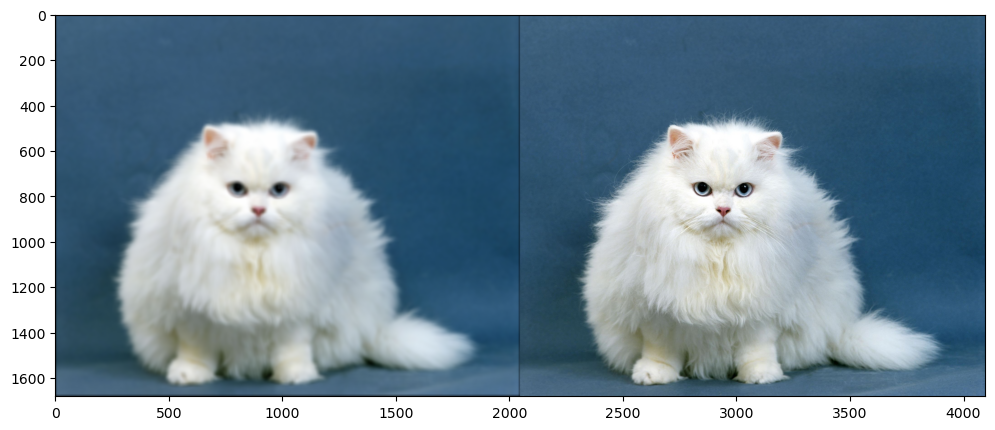

In [6]:

import jax.numpy as jnp
from jax.scipy.signal import convolve2d
from skimage.io import imread
from skimage.util import img_as_float32
from matplotlib import pyplot as plt

kernel_blur = jnp.ones((20,20))
kernel_blur /= jnp.sum(kernel_blur)
def color_convolution(image, kernel):
    channels = []
    for i in range(3):
        color_channel = image[:,:,i]
        filtered_channel = convolve2d(color_channel, kernel, mode="same")
        filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
        channels.append(filtered_channel)
        final_image = jnp.stack(channels, axis=2)
    return final_image
img = img_as_float32(imread('cat.jpeg'))
img_blur = color_convolution(img, kernel_blur)
plt.figure(figsize = (12,10))
plt.imshow(jnp.hstack((img_blur, img)));

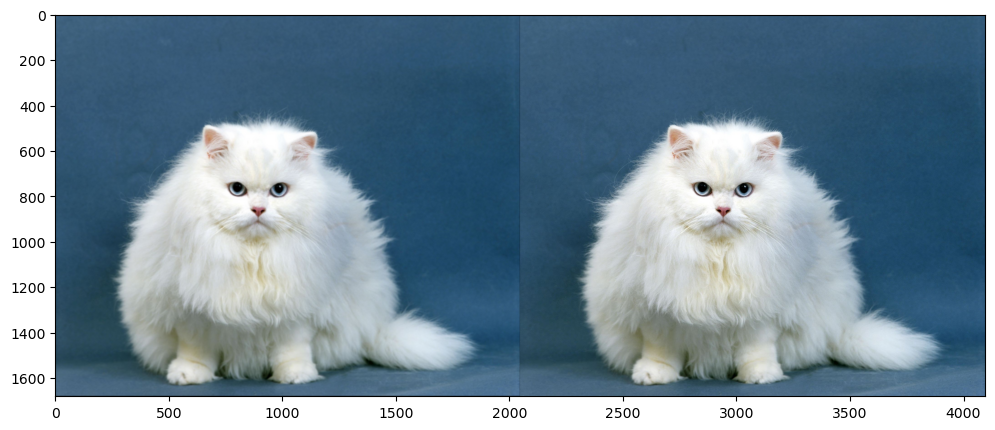

In [13]:
import jax.numpy as jnp
from jax.scipy.signal import convolve2d
from skimage.io import imread
from skimage.util import img_as_float32
from matplotlib import pyplot as plt

kernel_blur = jnp.ones((5,5))
kernel_blur /= jnp.sum(kernel_blur)

def matrix_filter(channel, kernel):
    filtered_channel = convolve2d(channel, kernel, mode="same")
    filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
    return filtered_channel

color_convolution_vmap = jax.vmap(matrix_filter, in_axes=(2, None), out_axes=2)
img = img_as_float32(imread('cat.jpeg'))
img_blur = color_convolution_vmap(img, kernel_blur)
plt.figure(figsize = (12,10))
plt.imshow(jnp.hstack((img_blur, img)));

In [14]:
%timeit color_convolution(img, kernel_blur).block_until_ready()
%timeit color_convolution_vmap(img, kernel_blur).block_until_ready()

190 ms ± 4.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
223 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
color_convolution_jit = jax.jit(color_convolution)
color_convolution_vmap_jit = jax.jit(color_convolution_vmap)
color_convolution_jit(img, kernel_blur).block_until_ready()
color_convolution_vmap_jit(img, kernel_blur).block_until_ready();

In [16]:
%timeit color_convolution_jit(img, kernel_blur).block_until_ready()
%timeit color_convolution_vmap_jit(img, kernel_blur).block_until_ready()

57.2 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.6 ms ± 731 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
